In [1]:
import ssbc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
p_class1 = 0.20
beta_params_class0 = (1,7)
beta_params_class1 = (5,2)

alpha_0 = 0.10
delta_0 = 0.10
alpha_1 = 0.10
delta_1 = 0.10

In [3]:
sampler = ssbc.simulation.BinaryClassifierSimulator(
    p_class1=p_class1, 
    beta_params_class0=beta_params_class0,
    beta_params_class1=beta_params_class1)

In [4]:
labels , probs = sampler.generate(1000)
class_data = ssbc.split_by_class(labels=labels, probs=probs)

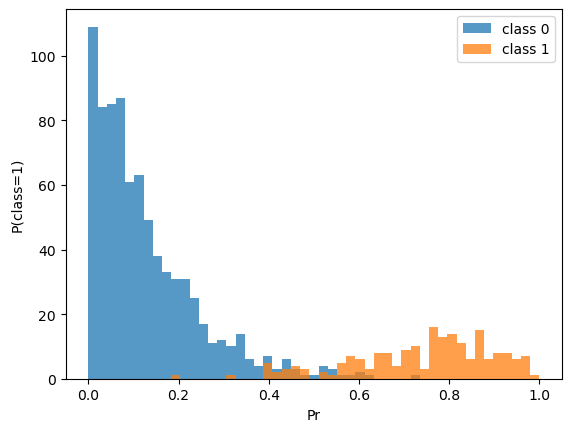

In [5]:
plt.hist(class_data[0]['probs'][:,1], bins=np.linspace(0,1,50), alpha=0.75)
plt.hist(class_data[1]['probs'][:,1], bins=np.linspace(0,1,50), alpha=0.75)
plt.legend(["class 0", "class 1"])
plt.ylabel('P(class=1)')
plt.xlabel("Pr")
plt.show()

In [6]:
cal_result, pred_stats = ssbc.mondrian_conformal_calibrate(
    alpha_target={0: alpha_0, 1: alpha_1},
    delta={0: delta_0, 1: delta_1}, 
    class_data=class_data)       

op_bounds = ssbc.compute_mondrian_operational_bounds(calibration_result=cal_result, 
                                                     labels=labels, probs=probs,ci_width=0.95, n_jobs=-1)

marginal_bounds = ssbc.compute_marginal_operational_bounds(labels=labels, 
                                                           probs=probs, 
                                                           alpha_target=0.10, 
                                                           delta_coverage=0.05, 
                                                           ci_width=.95, n_jobs=-1) 


summary = ssbc.report_prediction_stats(pred_stats, cal_result, op_bounds, marginal_bounds)


MONDRIAN CONFORMAL PREDICTION REPORT

CLASS 0 (Conditioned on True Label = 0)
  Calibration size: n = 804
  Target miscoverage: α = 0.100
  SSBC-corrected α:   α' = 0.0870
  PAC risk:           δ = 0.100
  Conformal threshold: 0.3031

  📊 Statistics from Calibration Data (n=804):
     [Basic CP CIs without PAC guarantee - evaluated on calibration data]
    Abstentions:    53 /  804 =  6.59%  95% CI: [0.050, 0.085]
    Singletons:    751 /  804 = 93.41%  95% CI: [0.915, 0.950]
      Correct:     735 /  804 = 91.42%  95% CI: [0.893, 0.933]
      Incorrect:    16 /  804 =  1.99%  95% CI: [0.011, 0.032]
    Error | singleton:   16 /  751 =  2.13%  95% CI: [0.012, 0.034]
    Doublets:        0 /  804 =  0.00%  95% CI: [0.000, 0.005]

  📐 PAC Singleton Error Bound (δ=0.100):
     ρ = 14.170, κ = 1.000
     α'_bound:    0.0365
     α'_observed: 0.0213 ✓

  ✅ RIGOROUS Operational Bounds (LOO-CV)
     CI width: 95.0%
     Calibration size: n = 804

     ABSTENTION:
       Bounds: [0.052, 0.082]

In [7]:
from ssbc import compute_pac_operational_metrics

result = compute_pac_operational_metrics(
    y_cal=labels,
    probs_cal=probs,
    alpha=0.10,      # Target 10% miscoverage
    delta=0.10,      # 90% PAC confidence  
    ci_level=0.95,   # 95% CIs on operational rates
    class_label=1    # Focus on class 1
)

print(f"Singleton rate: [{result['singleton_rate_ci'][0]:.3f}, "
      f"{result['singleton_rate_ci'][1]:.3f}]")

Singleton rate: [0.002, 0.151]


In [8]:
# Complete Rigorous PAC Report for Conformal Prediction
from ssbc import BinaryClassifierSimulator, generate_rigorous_pac_report

# Generate imbalanced binary classification data
sim = BinaryClassifierSimulator(
    p_class1=0.20,  # 20% minority class
    beta_params_class0=(1, 7),  # Class 0: skewed toward high prob
    beta_params_class1=(3, 2),  # Class 1: skewed toward low prob
    seed=42
)
labels, probs = sim.generate(n_samples=1300)

# Generate comprehensive PAC report
report = generate_rigorous_pac_report(
    labels=labels,
    probs=probs,
    alpha_target=0.10,      # 10% target miscoverage per class
    delta=0.10,             # 10% PAC risk per class
    test_size=500,          # Expected test set size
    ci_level=0.95,          # 95% Clopper-Pearson intervals
    use_union_bound=True,   # All metrics hold simultaneously
    verbose=True            # Print full report
)

# Access programmatic results
print("\n" + "="*80)
print("PROGRAMMATIC ACCESS")
print("="*80)

# Per-class bounds
pac_0 = report['pac_bounds_class_0']
pac_1 = report['pac_bounds_class_1']

print(f"\nClass 0 (n={report['ssbc_class_0'].n}):")
print(f"  Singleton rate: [{pac_0['singleton_rate_bounds'][0]:.3f}, {pac_0['singleton_rate_bounds'][1]:.3f}]")
print(f"  Expected:       {pac_0['expected_singleton_rate']:.3f}")

print(f"\nClass 1 (n={report['ssbc_class_1'].n}):")
print(f"  Singleton rate: [{pac_1['singleton_rate_bounds'][0]:.3f}, {pac_1['singleton_rate_bounds'][1]:.3f}]")
print(f"  Expected:       {pac_1['expected_singleton_rate']:.3f}")

# Marginal bounds (entire dataset)
pac_marg = report['pac_bounds_marginal']
print(f"\nMarginal (all samples):")
print(f"  Singleton rate:      [{pac_marg['singleton_rate_bounds'][0]:.3f}, {pac_marg['singleton_rate_bounds'][1]:.3f}]")
print(f"  Doublet rate:        [{pac_marg['doublet_rate_bounds'][0]:.3f}, {pac_marg['doublet_rate_bounds'][1]:.3f}]")
print(f"  Abstention rate:     [{pac_marg['abstention_rate_bounds'][0]:.3f}, {pac_marg['abstention_rate_bounds'][1]:.3f}]")
print(f"  Singleton error rate: [{pac_marg['singleton_error_rate_bounds'][0]:.3f}, {pac_marg['singleton_error_rate_bounds'][1]:.3f}]")

RIGOROUS PAC-CONTROLLED CONFORMAL PREDICTION REPORT

Parameters:
  Test size: 500
  CI level: 95% (Clopper-Pearson)
  PAC confidence: Class 0: 90%, Class 1: 90%, Marginal: 81%
  Union bound: YES (all metrics hold simultaneously)

CLASS 0 (Conditioned on True Label = 0)
  Calibration size: n = 1042
  Target miscoverage: α = 0.100
  SSBC-corrected α:   α' = 0.0882
  PAC risk:           δ = 0.100
  Conformal threshold: 0.2789

  📊 Statistics from Calibration Data (n=1042):
     [Basic CP CIs without PAC guarantee - evaluated on calibration data]
    Abstentions:         0 / 1042 =  0.00%  95% CI: [0.000, 0.004]
    Singletons:       1035 / 1042 = 99.33%  95% CI: [0.986, 0.997]
      Correct:         944 / 1042 = 90.60%  95% CI: [0.887, 0.923]
      Incorrect:        91 / 1042 =  8.73%  95% CI: [0.071, 0.106]
    Error | singleton:    91 / 1035 =  8.79%  95% CI: [0.071, 0.107]
    Doublets:            7 / 1042 =  0.67%  95% CI: [0.003, 0.014]

  ✅ RIGOROUS PAC-Controlled Operational Bounds

In [9]:
# Complete Rigorous PAC Report for Conformal Prediction
from ssbc import BinaryClassifierSimulator, generate_rigorous_pac_report

# Generate imbalanced binary classification data
sim = BinaryClassifierSimulator(
    p_class1=0.20,  # 20% minority class
    beta_params_class0=(1, 7),  # Class 0: skewed toward high prob
    beta_params_class1=(5, 2),  # Class 1: skewed toward low prob
    seed=42
)
labels, probs = sim.generate(n_samples=300)

# Generate comprehensive PAC report
report = generate_rigorous_pac_report(
    labels=labels,
    probs=probs,
    alpha_target=0.10,      # 10% target miscoverage per class
    delta=0.10,             # 10% PAC risk per class
    test_size=300,          # Expected test set size
    ci_level=0.95,          # 95% Clopper-Pearson intervals
    use_union_bound=True,   # All metrics hold simultaneously
    verbose=True            # Print full report
)

# Access programmatic results
print("\n" + "="*80)
print("PROGRAMMATIC ACCESS")
print("="*80)

# Per-class bounds
pac_0 = report['pac_bounds_class_0']
pac_1 = report['pac_bounds_class_1']

print(f"\nClass 0 (n={report['ssbc_class_0'].n}):")
print(f"  Singleton rate: [{pac_0['singleton_rate_bounds'][0]:.3f}, {pac_0['singleton_rate_bounds'][1]:.3f}]")
print(f"  Expected:       {pac_0['expected_singleton_rate']:.3f}")

print(f"\nClass 1 (n={report['ssbc_class_1'].n}):")
print(f"  Singleton rate: [{pac_1['singleton_rate_bounds'][0]:.3f}, {pac_1['singleton_rate_bounds'][1]:.3f}]")
print(f"  Expected:       {pac_1['expected_singleton_rate']:.3f}")

# Marginal bounds (entire dataset)
pac_marg = report['pac_bounds_marginal']
print(f"\nMarginal (all samples):")
print(f"  Singleton:      [{pac_marg['singleton_rate_bounds'][0]:.3f}, {pac_marg['singleton_rate_bounds'][1]:.3f}]")
print(f"  Doublet:        [{pac_marg['doublet_rate_bounds'][0]:.3f}, {pac_marg['doublet_rate_bounds'][1]:.3f}]")
print(f"  Abstention:     [{pac_marg['abstention_rate_bounds'][0]:.3f}, {pac_marg['abstention_rate_bounds'][1]:.3f}]")
print(f"  Singleton error: [{pac_marg['singleton_error_rate_bounds'][0]:.3f}, {pac_marg['singleton_error_rate_bounds'][1]:.3f}]")

RIGOROUS PAC-CONTROLLED CONFORMAL PREDICTION REPORT

Parameters:
  Test size: 300
  CI level: 95% (Clopper-Pearson)
  PAC confidence: Class 0: 90%, Class 1: 90%, Marginal: 81%
  Union bound: YES (all metrics hold simultaneously)

CLASS 0 (Conditioned on True Label = 0)
  Calibration size: n = 243
  Target miscoverage: α = 0.100
  SSBC-corrected α:   α' = 0.0738
  PAC risk:           δ = 0.100
  Conformal threshold: 0.3474

  📊 Statistics from Calibration Data (n=243):
     [Basic CP CIs without PAC guarantee - evaluated on calibration data]
    Abstentions:         6 /  243 =  2.47%  95% CI: [0.009, 0.053]
    Singletons:        237 /  243 = 97.53%  95% CI: [0.947, 0.991]
      Correct:         226 /  243 = 93.00%  95% CI: [0.890, 0.959]
      Incorrect:        11 /  243 =  4.53%  95% CI: [0.023, 0.080]
    Error | singleton:    11 /  237 =  4.64%  95% CI: [0.023, 0.082]
    Doublets:            0 /  243 =  0.00%  95% CI: [0.000, 0.015]

  ✅ RIGOROUS PAC-Controlled Operational Bounds
 

In [10]:
# Empirical Validation of PAC Bounds
import numpy as np
from ssbc import BinaryClassifierSimulator, generate_rigorous_pac_report

import matplotlib.pyplot as plt
import numpy as np
from ssbc import BinaryClassifierSimulator, generate_rigorous_pac_report

# [Include the validate_pac_bounds function from before]

def plot_validation_histograms(validation, figsize=(16, 12)):
    """Create histograms for all simulated rates with PAC bounds.
    
    Parameters
    ----------
    validation : dict
        Output from validate_pac_bounds()
    figsize : tuple
        Figure size (width, height)
    """
    fig, axes = plt.subplots(3, 4, figsize=figsize)
    fig.suptitle(f'Empirical Rate Distributions ({validation["n_trials"]} trials)', 
                 fontsize=16, fontweight='bold')
    
    metrics = ['singleton', 'doublet', 'abstention', 'singleton_error']
    metric_names = ['Singleton Rate', 'Doublet Rate', 'Abstention Rate', 'Singleton Error Rate']
    
    # Row 0: Marginal
    for col, (metric, name) in enumerate(zip(metrics, metric_names)):
        ax = axes[0, col]
        m = validation['marginal'][metric]
        
        # Filter out NaNs
        rates = m['rates']
        if metric == 'singleton_error':
            rates = rates[~np.isnan(rates)]
        
        # Histogram
        ax.hist(rates, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        
        # PAC bounds
        lower, upper = m['bounds']
        ax.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'Lower: {lower:.3f}')
        ax.axvline(upper, color='red', linestyle='--', linewidth=2, label=f'Upper: {upper:.3f}')
        
        # Expected value
        ax.axvline(m['expected'], color='green', linestyle='-', linewidth=2, label=f'Expected: {m["expected"]:.3f}')
        
        # Empirical mean
        ax.axvline(m['mean'], color='orange', linestyle=':', linewidth=2, label=f'Mean: {m["mean"]:.3f}')
        
        # Coverage
        coverage = m['empirical_coverage']
        ax.set_title(f'MARGINAL: {name}\nCoverage: {coverage:.1%}', fontweight='bold')
        ax.set_xlabel('Rate')
        ax.set_ylabel('Frequency')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Row 1: Class 0
    for col, (metric, name) in enumerate(zip(metrics, metric_names)):
        ax = axes[1, col]
        m = validation['class_0'][metric]
        
        # Filter out NaNs
        rates = m['rates']
        if metric == 'singleton_error':
            rates = rates[~np.isnan(rates)]
        
        # Histogram
        ax.hist(rates, bins=50, alpha=0.7, color='coral', edgecolor='black')
        
        # PAC bounds
        lower, upper = m['bounds']
        ax.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'Lower: {lower:.3f}')
        ax.axvline(upper, color='red', linestyle='--', linewidth=2, label=f'Upper: {upper:.3f}')
        
        # Expected value
        ax.axvline(m['expected'], color='green', linestyle='-', linewidth=2, label=f'Expected: {m["expected"]:.3f}')
        
        # Empirical mean
        ax.axvline(m['mean'], color='orange', linestyle=':', linewidth=2, label=f'Mean: {m["mean"]:.3f}')
        
        # Coverage
        coverage = m['empirical_coverage']
        ax.set_title(f'CLASS 0: {name}\nCoverage: {coverage:.1%}', fontweight='bold')
        ax.set_xlabel('Rate')
        ax.set_ylabel('Frequency')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Row 2: Class 1
    for col, (metric, name) in enumerate(zip(metrics, metric_names)):
        ax = axes[2, col]
        m = validation['class_1'][metric]
        
        # Filter out NaNs
        rates = m['rates']
        if metric == 'singleton_error':
            rates = rates[~np.isnan(rates)]
        
        # Histogram
        ax.hist(rates, bins=50, alpha=0.7, color='mediumpurple', edgecolor='black')
        
        # PAC bounds
        lower, upper = m['bounds']
        ax.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'Lower: {lower:.3f}')
        ax.axvline(upper, color='red', linestyle='--', linewidth=2, label=f'Upper: {upper:.3f}')
        
        # Expected value
        ax.axvline(m['expected'], color='green', linestyle='-', linewidth=2, label=f'Expected: {m["expected"]:.3f}')
        
        # Empirical mean
        ax.axvline(m['mean'], color='orange', linestyle=':', linewidth=2, label=f'Mean: {m["mean"]:.3f}')
        
        # Coverage
        coverage = m['empirical_coverage']
        ax.set_title(f'CLASS 1: {name}\nCoverage: {coverage:.1%}', fontweight='bold')
        ax.set_xlabel('Rate')
        ax.set_ylabel('Frequency')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# COMPLETE VALIDATION WORKFLOW WITH HISTOGRAMS
# ============================================

# Step 1: Generate calibration data and compute PAC bounds
print("Step 1: Generating calibration data and computing PAC bounds...")
sim = BinaryClassifierSimulator(
    p_class1=0.20,
    beta_params_class0=(1, 7),
    beta_params_class1=(5, 2),
    seed=42
)
labels, probs = sim.generate(n_samples=300)

report = generate_rigorous_pac_report(
    labels=labels,
    probs=probs,
    alpha_target=0.10,
    delta=0.10,
    test_size=300,
    ci_level=0.95,
    use_union_bound=True,
    verbose=True
)

# Step 2: Validate with 1000 independent test sets
print("\n\nStep 2: Running empirical validation (1000 trials)...")
validation = validate_pac_bounds(
    report=report,
    simulator=sim,
    test_size=300,
    n_trials=1000,
    seed=123
)

# Step 3: Print validation results
print_validation_results(validation)

# Step 4: Plot histograms
print("\n\nStep 3: Creating histogram visualizations...")
fig = plot_validation_histograms(validation)
plt.savefig('pac_validation_histograms.png', dpi=300, bbox_inches='tight')
print("✅ Histograms saved to: pac_validation_histograms.png")
plt.show()

# Step 5: Summary statistics
print("\n" + "="*80)
print("SUMMARY: PAC GUARANTEE VERIFICATION")
print("="*80)

pac_level_marginal = report['parameters']['pac_level_marginal']
pac_level_0 = report['parameters']['pac_level_0']
pac_level_1 = report['parameters']['pac_level_1']

print(f"\nTarget PAC levels:")
print(f"  Marginal: {pac_level_marginal:.1%}")
print(f"  Class 0:  {pac_level_0:.1%}")
print(f"  Class 1:  {pac_level_1:.1%}")

print(f"\nEmpirical coverage (fraction of trials within PAC bounds):")
print(f"\n  Marginal:")
for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
    cov = validation['marginal'][metric]['empirical_coverage']
    status = "✅" if cov >= pac_level_marginal * 0.95 else "⚠️"
    print(f"    {metric:20s}: {cov:.1%} {status}")

print(f"\n  Class 0:")
for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
    cov = validation['class_0'][metric]['empirical_coverage']
    status = "✅" if cov >= pac_level_0 * 0.95 else "⚠️"
    print(f"    {metric:20s}: {cov:.1%} {status}")

print(f"\n  Class 1:")
for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
    cov = validation['class_1'][metric]['empirical_coverage']
    status = "✅" if cov >= pac_level_1 * 0.95 else "⚠️"
    print(f"    {metric:20s}: {cov:.1%} {status}")

print("\nNote: Coverage should be ≥ target PAC level (within finite-sample variance)")
print("="*80)

def validate_pac_bounds(report, simulator, test_size, n_trials=1000, seed=None):
    """Run n_trials independent test sets and check if rates fall within PAC bounds.
    
    Parameters
    ----------
    report : dict
        Output from generate_rigorous_pac_report()
    simulator : BinaryClassifierSimulator
        Simulator to generate test data
    test_size : int
        Size of each test set
    n_trials : int
        Number of independent trials
    seed : int, optional
        Random seed for reproducibility
        
    Returns
    -------
    dict
        Validation results with empirical coverage rates
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Extract thresholds from calibration
    threshold_0 = report['calibration_result'][0]['threshold']
    threshold_1 = report['calibration_result'][1]['threshold']
    
    # Storage for realized rates
    marginal_singleton_rates = []
    marginal_doublet_rates = []
    marginal_abstention_rates = []
    marginal_singleton_error_rates = []
    
    class_0_singleton_rates = []
    class_0_doublet_rates = []
    class_0_abstention_rates = []
    class_0_singleton_error_rates = []
    
    class_1_singleton_rates = []
    class_1_doublet_rates = []
    class_1_abstention_rates = []
    class_1_singleton_error_rates = []
    
    # Run trials
    for trial in range(n_trials):
        # Generate independent test set
        labels_test, probs_test = simulator.generate(test_size)
        
        # Apply Mondrian thresholds and evaluate
        n_total = len(labels_test)
        n_singletons = 0
        n_doublets = 0
        n_abstentions = 0
        n_singletons_correct = 0
        
        # Per-class counters
        class_0_mask = labels_test == 0
        class_1_mask = labels_test == 1
        
        n_0 = np.sum(class_0_mask)
        n_1 = np.sum(class_1_mask)
        
        n_singletons_0 = 0
        n_doublets_0 = 0
        n_abstentions_0 = 0
        n_singletons_correct_0 = 0
        
        n_singletons_1 = 0
        n_doublets_1 = 0
        n_abstentions_1 = 0
        n_singletons_correct_1 = 0
        
        for i in range(n_total):
            true_label = labels_test[i]
            score_0 = 1.0 - probs_test[i, 0]
            score_1 = 1.0 - probs_test[i, 1]
            
            # Build prediction set
            in_0 = score_0 <= threshold_0
            in_1 = score_1 <= threshold_1
            
            # Marginal counts
            if in_0 and in_1:
                n_doublets += 1
            elif in_0 or in_1:
                n_singletons += 1
                if (in_0 and true_label == 0) or (in_1 and true_label == 1):
                    n_singletons_correct += 1
            else:
                n_abstentions += 1
            
            # Per-class counts
            if true_label == 0:
                if in_0 and in_1:
                    n_doublets_0 += 1
                elif in_0 or in_1:
                    n_singletons_0 += 1
                    if in_0:
                        n_singletons_correct_0 += 1
                else:
                    n_abstentions_0 += 1
            else:  # true_label == 1
                if in_0 and in_1:
                    n_doublets_1 += 1
                elif in_0 or in_1:
                    n_singletons_1 += 1
                    if in_1:
                        n_singletons_correct_1 += 1
                else:
                    n_abstentions_1 += 1
        
        # Compute marginal rates
        marginal_singleton_rates.append(n_singletons / n_total)
        marginal_doublet_rates.append(n_doublets / n_total)
        marginal_abstention_rates.append(n_abstentions / n_total)
        
        singleton_error_rate = (
            (n_singletons - n_singletons_correct) / n_singletons 
            if n_singletons > 0 else np.nan
        )
        marginal_singleton_error_rates.append(singleton_error_rate)
        
        # Compute per-class rates
        if n_0 > 0:
            class_0_singleton_rates.append(n_singletons_0 / n_0)
            class_0_doublet_rates.append(n_doublets_0 / n_0)
            class_0_abstention_rates.append(n_abstentions_0 / n_0)
            singleton_error_0 = (
                (n_singletons_0 - n_singletons_correct_0) / n_singletons_0 
                if n_singletons_0 > 0 else np.nan
            )
            class_0_singleton_error_rates.append(singleton_error_0)
        
        if n_1 > 0:
            class_1_singleton_rates.append(n_singletons_1 / n_1)
            class_1_doublet_rates.append(n_doublets_1 / n_1)
            class_1_abstention_rates.append(n_abstentions_1 / n_1)
            singleton_error_1 = (
                (n_singletons_1 - n_singletons_correct_1) / n_singletons_1 
                if n_singletons_1 > 0 else np.nan
            )
            class_1_singleton_error_rates.append(singleton_error_1)
    
    # Convert to arrays
    marginal_singleton_rates = np.array(marginal_singleton_rates)
    marginal_doublet_rates = np.array(marginal_doublet_rates)
    marginal_abstention_rates = np.array(marginal_abstention_rates)
    marginal_singleton_error_rates = np.array(marginal_singleton_error_rates)
    
    class_0_singleton_rates = np.array(class_0_singleton_rates)
    class_0_doublet_rates = np.array(class_0_doublet_rates)
    class_0_abstention_rates = np.array(class_0_abstention_rates)
    class_0_singleton_error_rates = np.array(class_0_singleton_error_rates)
    
    class_1_singleton_rates = np.array(class_1_singleton_rates)
    class_1_doublet_rates = np.array(class_1_doublet_rates)
    class_1_abstention_rates = np.array(class_1_abstention_rates)
    class_1_singleton_error_rates = np.array(class_1_singleton_error_rates)
    
    # Check coverage (how many trials fall within bounds)
    def check_coverage(rates, bounds):
        """Check what fraction of rates fall within bounds."""
        lower, upper = bounds
        within = np.sum((rates >= lower) & (rates <= upper))
        return within / len(rates)
    
    def check_coverage_with_nan(rates, bounds):
        """Check coverage, ignoring NaN values."""
        lower, upper = bounds
        valid = ~np.isnan(rates)
        if np.sum(valid) == 0:
            return np.nan
        rates_valid = rates[valid]
        within = np.sum((rates_valid >= lower) & (rates_valid <= upper))
        return within / len(rates_valid)
    
    # Get bounds from report
    pac_marg = report['pac_bounds_marginal']
    pac_0 = report['pac_bounds_class_0']
    pac_1 = report['pac_bounds_class_1']
    
    return {
        'n_trials': n_trials,
        'test_size': test_size,
        'marginal': {
            'singleton': {
                'rates': marginal_singleton_rates,
                'mean': np.mean(marginal_singleton_rates),
                'std': np.std(marginal_singleton_rates),
                'bounds': pac_marg['singleton_rate_bounds'],
                'expected': pac_marg['expected_singleton_rate'],
                'empirical_coverage': check_coverage(marginal_singleton_rates, pac_marg['singleton_rate_bounds']),
            },
            'doublet': {
                'rates': marginal_doublet_rates,
                'mean': np.mean(marginal_doublet_rates),
                'std': np.std(marginal_doublet_rates),
                'bounds': pac_marg['doublet_rate_bounds'],
                'expected': pac_marg['expected_doublet_rate'],
                'empirical_coverage': check_coverage(marginal_doublet_rates, pac_marg['doublet_rate_bounds']),
            },
            'abstention': {
                'rates': marginal_abstention_rates,
                'mean': np.mean(marginal_abstention_rates),
                'std': np.std(marginal_abstention_rates),
                'bounds': pac_marg['abstention_rate_bounds'],
                'expected': pac_marg['expected_abstention_rate'],
                'empirical_coverage': check_coverage(marginal_abstention_rates, pac_marg['abstention_rate_bounds']),
            },
            'singleton_error': {
                'rates': marginal_singleton_error_rates,
                'mean': np.nanmean(marginal_singleton_error_rates),
                'std': np.nanstd(marginal_singleton_error_rates),
                'bounds': pac_marg['singleton_error_rate_bounds'],
                'expected': pac_marg['expected_singleton_error_rate'],
                'empirical_coverage': check_coverage_with_nan(marginal_singleton_error_rates, pac_marg['singleton_error_rate_bounds']),
            },
        },
        'class_0': {
            'singleton': {
                'rates': class_0_singleton_rates,
                'mean': np.mean(class_0_singleton_rates),
                'bounds': pac_0['singleton_rate_bounds'],
                'expected': pac_0['expected_singleton_rate'],
                'empirical_coverage': check_coverage(class_0_singleton_rates, pac_0['singleton_rate_bounds']),
            },
            'doublet': {
                'rates': class_0_doublet_rates,
                'mean': np.mean(class_0_doublet_rates),
                'bounds': pac_0['doublet_rate_bounds'],
                'expected': pac_0['expected_doublet_rate'],
                'empirical_coverage': check_coverage(class_0_doublet_rates, pac_0['doublet_rate_bounds']),
            },
            'abstention': {
                'rates': class_0_abstention_rates,
                'mean': np.mean(class_0_abstention_rates),
                'bounds': pac_0['abstention_rate_bounds'],
                'expected': pac_0['expected_abstention_rate'],
                'empirical_coverage': check_coverage(class_0_abstention_rates, pac_0['abstention_rate_bounds']),
            },
            'singleton_error': {
                'rates': class_0_singleton_error_rates,
                'mean': np.nanmean(class_0_singleton_error_rates),
                'bounds': pac_0['singleton_error_rate_bounds'],
                'expected': pac_0['expected_singleton_error_rate'],
                'empirical_coverage': check_coverage_with_nan(class_0_singleton_error_rates, pac_0['singleton_error_rate_bounds']),
            },
        },
        'class_1': {
            'singleton': {
                'rates': class_1_singleton_rates,
                'mean': np.mean(class_1_singleton_rates),
                'bounds': pac_1['singleton_rate_bounds'],
                'expected': pac_1['expected_singleton_rate'],
                'empirical_coverage': check_coverage(class_1_singleton_rates, pac_1['singleton_rate_bounds']),
            },
            'doublet': {
                'rates': class_1_doublet_rates,
                'mean': np.mean(class_1_doublet_rates),
                'bounds': pac_1['doublet_rate_bounds'],
                'expected': pac_1['expected_doublet_rate'],
                'empirical_coverage': check_coverage(class_1_doublet_rates, pac_1['doublet_rate_bounds']),
            },
            'abstention': {
                'rates': class_1_abstention_rates,
                'mean': np.mean(class_1_abstention_rates),
                'bounds': pac_1['abstention_rate_bounds'],
                'expected': pac_1['expected_abstention_rate'],
                'empirical_coverage': check_coverage(class_1_abstention_rates, pac_1['abstention_rate_bounds']),
            },
            'singleton_error': {
                'rates': class_1_singleton_error_rates,
                'mean': np.nanmean(class_1_singleton_error_rates),
                'bounds': pac_1['singleton_error_rate_bounds'],
                'expected': pac_1['expected_singleton_error_rate'],
                'empirical_coverage': check_coverage_with_nan(class_1_singleton_error_rates, pac_1['singleton_error_rate_bounds']),
            },
        },
    }


# Print validation results
def print_validation_results(validation):
    """Pretty print validation results."""
    print("="*80)
    print(f"EMPIRICAL VALIDATION ({validation['n_trials']} trials, test_size={validation['test_size']})")
    print("="*80)
    
    # Marginal results
    print("\nMARGINAL (All Samples):")
    print("-"*80)
    for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
        m = validation['marginal'][metric]
        lower, upper = m['bounds']
        print(f"\n{metric.upper().replace('_', ' ')}:")
        print(f"  Empirical mean:  {m['mean']:.4f} ± {m['std']:.4f}")
        print(f"  Expected (pred): {m['expected']:.4f}")
        print(f"  PAC bounds:      [{lower:.4f}, {upper:.4f}]")
        print(f"  Coverage:        {m['empirical_coverage']:.1%} (target: ≥{validation['marginal']['singleton']['bounds']})")
    
    # Per-class results
    for class_label in [0, 1]:
        print(f"\nCLASS {class_label}:")
        print("-"*80)
        for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
            m = validation[f'class_{class_label}'][metric]
            lower, upper = m['bounds']
            print(f"\n{metric.upper().replace('_', ' ')}:")
            print(f"  Empirical mean:  {m['mean']:.4f}")
            print(f"  Expected (pred): {m['expected']:.4f}")
            print(f"  PAC bounds:      [{lower:.4f}, {upper:.4f}]")
            print(f"  Coverage:        {m['empirical_coverage']:.1%}")


# USAGE EXAMPLE
# ============

# Step 1: Generate calibration data and compute PAC bounds
sim = BinaryClassifierSimulator(
    p_class1=0.20,
    beta_params_class0=(1, 7),
    beta_params_class1=(5, 2),
    seed=42
)
labels, probs = sim.generate(n_samples=300)

report = generate_rigorous_pac_report(
    labels=labels,
    probs=probs,
    alpha_target=0.10,
    delta=0.10,
    test_size=300,
    ci_level=0.95,
    use_union_bound=False,
    verbose=True
)

# Step 2: Validate with 1000 independent test sets
print("\n\nRunning empirical validation (1000 trials)...")
validation = validate_pac_bounds(
    report=report,
    simulator=sim,
    test_size=300,
    n_trials=1000,
    seed=123
)

# Step 3: Print validation results
print_validation_results(validation)

# Step 4: Check if PAC guarantees hold empirically
print("\n" + "="*80)
print("PAC GUARANTEE VERIFICATION")
print("="*80)
pac_level_marginal = report['parameters']['pac_level_marginal']
print(f"\nTarget PAC level (marginal): {pac_level_marginal:.1%}")
print("\nEmpirical coverage rates should be ≥ target (accounting for finite sample variance)")

Step 1: Generating calibration data and computing PAC bounds...
RIGOROUS PAC-CONTROLLED CONFORMAL PREDICTION REPORT

Parameters:
  Test size: 300
  CI level: 95% (Clopper-Pearson)
  PAC confidence: Class 0: 90%, Class 1: 90%, Marginal: 81%
  Union bound: YES (all metrics hold simultaneously)

CLASS 0 (Conditioned on True Label = 0)
  Calibration size: n = 243
  Target miscoverage: α = 0.100
  SSBC-corrected α:   α' = 0.0738
  PAC risk:           δ = 0.100
  Conformal threshold: 0.3474

  📊 Statistics from Calibration Data (n=243):
     [Basic CP CIs without PAC guarantee - evaluated on calibration data]
    Abstentions:         6 /  243 =  2.47%  95% CI: [0.009, 0.053]
    Singletons:        237 /  243 = 97.53%  95% CI: [0.947, 0.991]
      Correct:         226 /  243 = 93.00%  95% CI: [0.890, 0.959]
      Incorrect:        11 /  243 =  4.53%  95% CI: [0.023, 0.080]
    Error | singleton:    11 /  237 =  4.64%  95% CI: [0.023, 0.082]
    Doublets:            0 /  243 =  0.00%  95% CI: 

NameError: name 'validate_pac_bounds' is not defined

In [ ]:
# ============================================================================
# EMPIRICAL VALIDATION OF PAC BOUNDS
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from ssbc import BinaryClassifierSimulator, generate_rigorous_pac_report


def validate_pac_bounds(report, simulator, test_size, n_trials=1000, seed=None):
    """Run n_trials independent test sets and check if rates fall within PAC bounds.
    
    Parameters
    ----------
    report : dict
        Output from generate_rigorous_pac_report()
    simulator : BinaryClassifierSimulator
        Simulator to generate test data
    test_size : int
        Size of each test set
    n_trials : int
        Number of independent trials
    seed : int, optional
        Random seed for reproducibility
        
    Returns
    -------
    dict
        Validation results with empirical coverage rates
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Extract thresholds from calibration
    threshold_0 = report['calibration_result'][0]['threshold']
    threshold_1 = report['calibration_result'][1]['threshold']
    
    # Storage for realized rates
    marginal_singleton_rates = []
    marginal_doublet_rates = []
    marginal_abstention_rates = []
    marginal_singleton_error_rates = []
    
    class_0_singleton_rates = []
    class_0_doublet_rates = []
    class_0_abstention_rates = []
    class_0_singleton_error_rates = []
    
    class_1_singleton_rates = []
    class_1_doublet_rates = []
    class_1_abstention_rates = []
    class_1_singleton_error_rates = []
    
    # Run trials
    for trial in range(n_trials):
        # Generate independent test set
        labels_test, probs_test = simulator.generate(test_size)
        
        # Apply Mondrian thresholds and evaluate
        n_total = len(labels_test)
        n_singletons = 0
        n_doublets = 0
        n_abstentions = 0
        n_singletons_correct = 0
        
        # Per-class counters
        n_0 = np.sum(labels_test == 0)
        n_1 = np.sum(labels_test == 1)
        
        n_singletons_0 = 0
        n_doublets_0 = 0
        n_abstentions_0 = 0
        n_singletons_correct_0 = 0
        
        n_singletons_1 = 0
        n_doublets_1 = 0
        n_abstentions_1 = 0
        n_singletons_correct_1 = 0
        
        for i in range(n_total):
            true_label = labels_test[i]
            score_0 = 1.0 - probs_test[i, 0]
            score_1 = 1.0 - probs_test[i, 1]
            
            # Build prediction set
            in_0 = score_0 <= threshold_0
            in_1 = score_1 <= threshold_1
            
            # Marginal counts
            if in_0 and in_1:
                n_doublets += 1
            elif in_0 or in_1:
                n_singletons += 1
                if (in_0 and true_label == 0) or (in_1 and true_label == 1):
                    n_singletons_correct += 1
            else:
                n_abstentions += 1
            
            # Per-class counts
            if true_label == 0:
                if in_0 and in_1:
                    n_doublets_0 += 1
                elif in_0 or in_1:
                    n_singletons_0 += 1
                    if in_0:
                        n_singletons_correct_0 += 1
                else:
                    n_abstentions_0 += 1
            else:  # true_label == 1
                if in_0 and in_1:
                    n_doublets_1 += 1
                elif in_0 or in_1:
                    n_singletons_1 += 1
                    if in_1:
                        n_singletons_correct_1 += 1
                else:
                    n_abstentions_1 += 1
        
        # Compute marginal rates
        marginal_singleton_rates.append(n_singletons / n_total)
        marginal_doublet_rates.append(n_doublets / n_total)
        marginal_abstention_rates.append(n_abstentions / n_total)
        
        singleton_error_rate = (
            (n_singletons - n_singletons_correct) / n_singletons 
            if n_singletons > 0 else np.nan
        )
        marginal_singleton_error_rates.append(singleton_error_rate)
        
        # Compute per-class rates
        if n_0 > 0:
            class_0_singleton_rates.append(n_singletons_0 / n_0)
            class_0_doublet_rates.append(n_doublets_0 / n_0)
            class_0_abstention_rates.append(n_abstentions_0 / n_0)
            singleton_error_0 = (
                (n_singletons_0 - n_singletons_correct_0) / n_singletons_0 
                if n_singletons_0 > 0 else np.nan
            )
            class_0_singleton_error_rates.append(singleton_error_0)
        
        if n_1 > 0:
            class_1_singleton_rates.append(n_singletons_1 / n_1)
            class_1_doublet_rates.append(n_doublets_1 / n_1)
            class_1_abstention_rates.append(n_abstentions_1 / n_1)
            singleton_error_1 = (
                (n_singletons_1 - n_singletons_correct_1) / n_singletons_1 
                if n_singletons_1 > 0 else np.nan
            )
            class_1_singleton_error_rates.append(singleton_error_1)
    
    # Convert to arrays
    marginal_singleton_rates = np.array(marginal_singleton_rates)
    marginal_doublet_rates = np.array(marginal_doublet_rates)
    marginal_abstention_rates = np.array(marginal_abstention_rates)
    marginal_singleton_error_rates = np.array(marginal_singleton_error_rates)
    
    class_0_singleton_rates = np.array(class_0_singleton_rates)
    class_0_doublet_rates = np.array(class_0_doublet_rates)
    class_0_abstention_rates = np.array(class_0_abstention_rates)
    class_0_singleton_error_rates = np.array(class_0_singleton_error_rates)
    
    class_1_singleton_rates = np.array(class_1_singleton_rates)
    class_1_doublet_rates = np.array(class_1_doublet_rates)
    class_1_abstention_rates = np.array(class_1_abstention_rates)
    class_1_singleton_error_rates = np.array(class_1_singleton_error_rates)
    
    # Check coverage functions
    def check_coverage(rates, bounds):
        """Check what fraction of rates fall within bounds."""
        lower, upper = bounds
        within = np.sum((rates >= lower) & (rates <= upper))
        return within / len(rates)
    
    def check_coverage_with_nan(rates, bounds):
        """Check coverage, ignoring NaN values."""
        lower, upper = bounds
        valid = ~np.isnan(rates)
        if np.sum(valid) == 0:
            return np.nan
        rates_valid = rates[valid]
        within = np.sum((rates_valid >= lower) & (rates_valid <= upper))
        return within / len(rates_valid)
    
    # Get bounds from report
    pac_marg = report['pac_bounds_marginal']
    pac_0 = report['pac_bounds_class_0']
    pac_1 = report['pac_bounds_class_1']
    
    return {
        'n_trials': n_trials,
        'test_size': test_size,
        'marginal': {
            'singleton': {
                'rates': marginal_singleton_rates,
                'mean': np.mean(marginal_singleton_rates),
                'std': np.std(marginal_singleton_rates),
                'bounds': pac_marg['singleton_rate_bounds'],
                'expected': pac_marg['expected_singleton_rate'],
                'empirical_coverage': check_coverage(marginal_singleton_rates, pac_marg['singleton_rate_bounds']),
            },
            'doublet': {
                'rates': marginal_doublet_rates,
                'mean': np.mean(marginal_doublet_rates),
                'std': np.std(marginal_doublet_rates),
                'bounds': pac_marg['doublet_rate_bounds'],
                'expected': pac_marg['expected_doublet_rate'],
                'empirical_coverage': check_coverage(marginal_doublet_rates, pac_marg['doublet_rate_bounds']),
            },
            'abstention': {
                'rates': marginal_abstention_rates,
                'mean': np.mean(marginal_abstention_rates),
                'std': np.std(marginal_abstention_rates),
                'bounds': pac_marg['abstention_rate_bounds'],
                'expected': pac_marg['expected_abstention_rate'],
                'empirical_coverage': check_coverage(marginal_abstention_rates, pac_marg['abstention_rate_bounds']),
            },
            'singleton_error': {
                'rates': marginal_singleton_error_rates,
                'mean': np.nanmean(marginal_singleton_error_rates),
                'std': np.nanstd(marginal_singleton_error_rates),
                'bounds': pac_marg['singleton_error_rate_bounds'],
                'expected': pac_marg['expected_singleton_error_rate'],
                'empirical_coverage': check_coverage_with_nan(marginal_singleton_error_rates, pac_marg['singleton_error_rate_bounds']),
            },
        },
        'class_0': {
            'singleton': {
                'rates': class_0_singleton_rates,
                'mean': np.mean(class_0_singleton_rates),
                'bounds': pac_0['singleton_rate_bounds'],
                'expected': pac_0['expected_singleton_rate'],
                'empirical_coverage': check_coverage(class_0_singleton_rates, pac_0['singleton_rate_bounds']),
            },
            'doublet': {
                'rates': class_0_doublet_rates,
                'mean': np.mean(class_0_doublet_rates),
                'bounds': pac_0['doublet_rate_bounds'],
                'expected': pac_0['expected_doublet_rate'],
                'empirical_coverage': check_coverage(class_0_doublet_rates, pac_0['doublet_rate_bounds']),
            },
            'abstention': {
                'rates': class_0_abstention_rates,
                'mean': np.mean(class_0_abstention_rates),
                'bounds': pac_0['abstention_rate_bounds'],
                'expected': pac_0['expected_abstention_rate'],
                'empirical_coverage': check_coverage(class_0_abstention_rates, pac_0['abstention_rate_bounds']),
            },
            'singleton_error': {
                'rates': class_0_singleton_error_rates,
                'mean': np.nanmean(class_0_singleton_error_rates),
                'bounds': pac_0['singleton_error_rate_bounds'],
                'expected': pac_0['expected_singleton_error_rate'],
                'empirical_coverage': check_coverage_with_nan(class_0_singleton_error_rates, pac_0['singleton_error_rate_bounds']),
            },
        },
        'class_1': {
            'singleton': {
                'rates': class_1_singleton_rates,
                'mean': np.mean(class_1_singleton_rates),
                'bounds': pac_1['singleton_rate_bounds'],
                'expected': pac_1['expected_singleton_rate'],
                'empirical_coverage': check_coverage(class_1_singleton_rates, pac_1['singleton_rate_bounds']),
            },
            'doublet': {
                'rates': class_1_doublet_rates,
                'mean': np.mean(class_1_doublet_rates),
                'bounds': pac_1['doublet_rate_bounds'],
                'expected': pac_1['expected_doublet_rate'],
                'empirical_coverage': check_coverage(class_1_doublet_rates, pac_1['doublet_rate_bounds']),
            },
            'abstention': {
                'rates': class_1_abstention_rates,
                'mean': np.mean(class_1_abstention_rates),
                'bounds': pac_1['abstention_rate_bounds'],
                'expected': pac_1['expected_abstention_rate'],
                'empirical_coverage': check_coverage(class_1_abstention_rates, pac_1['abstention_rate_bounds']),
            },
            'singleton_error': {
                'rates': class_1_singleton_error_rates,
                'mean': np.nanmean(class_1_singleton_error_rates),
                'bounds': pac_1['singleton_error_rate_bounds'],
                'expected': pac_1['expected_singleton_error_rate'],
                'empirical_coverage': check_coverage_with_nan(class_1_singleton_error_rates, pac_1['singleton_error_rate_bounds']),
            },
        },
    }


def print_validation_results(validation):
    """Pretty print validation results."""
    print("="*80)
    print(f"EMPIRICAL VALIDATION ({validation['n_trials']} trials, test_size={validation['test_size']})")
    print("="*80)
    
    # Marginal results
    print("\nMARGINAL (All Samples):")
    print("-"*80)
    for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
        m = validation['marginal'][metric]
        lower, upper = m['bounds']
        print(f"\n{metric.upper().replace('_', ' ')}:")
        print(f"  Empirical mean:  {m['mean']:.4f} ± {m['std']:.4f}")
        print(f"  Expected (pred): {m['expected']:.4f}")
        print(f"  PAC bounds:      [{lower:.4f}, {upper:.4f}]")
        print(f"  Coverage:        {m['empirical_coverage']:.1%}")
    
    # Per-class results
    for class_label in [0, 1]:
        print(f"\nCLASS {class_label}:")
        print("-"*80)
        for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
            m = validation[f'class_{class_label}'][metric]
            lower, upper = m['bounds']
            print(f"\n{metric.upper().replace('_', ' ')}:")
            print(f"  Empirical mean:  {m['mean']:.4f}")
            print(f"  Expected (pred): {m['expected']:.4f}")
            print(f"  PAC bounds:      [{lower:.4f}, {upper:.4f}]")
            print(f"  Coverage:        {m['empirical_coverage']:.1%}")


def plot_validation_histograms(validation, figsize=(16, 12)):
    """Create histograms for all simulated rates with PAC bounds."""
    fig, axes = plt.subplots(3, 4, figsize=figsize)
    fig.suptitle(f'Empirical Rate Distributions ({validation["n_trials"]} trials)', 
                 fontsize=16, fontweight='bold')
    
    metrics = ['singleton', 'doublet', 'abstention', 'singleton_error']
    metric_names = ['Singleton Rate', 'Doublet Rate', 'Abstention Rate', 'Singleton Error Rate']
    colors = ['steelblue', 'coral', 'mediumpurple']
    row_names = ['MARGINAL', 'CLASS 0', 'CLASS 1']
    data_keys = ['marginal', 'class_0', 'class_1']
    
    for row, (row_name, data_key, color) in enumerate(zip(row_names, data_keys, colors)):
        for col, (metric, name) in enumerate(zip(metrics, metric_names)):
            ax = axes[row, col]
            m = validation[data_key][metric]
            
            # Filter out NaNs
            rates = m['rates']
            if metric == 'singleton_error':
                rates = rates[~np.isnan(rates)]
            
            # Histogram
            ax.hist(rates, bins=50, alpha=0.7, color=color, edgecolor='black')
            
            # PAC bounds
            lower, upper = m['bounds']
            ax.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'Lower: {lower:.3f}')
            ax.axvline(upper, color='red', linestyle='--', linewidth=2, label=f'Upper: {upper:.3f}')
            
            # Expected value
            ax.axvline(m['expected'], color='green', linestyle='-', linewidth=2, label=f'Expected: {m["expected"]:.3f}')
            
            # Empirical mean
            ax.axvline(m['mean'], color='orange', linestyle=':', linewidth=2, label=f'Mean: {m["mean"]:.3f}')
            
            # Coverage
            coverage = m['empirical_coverage']
            ax.set_title(f'{row_name}: {name}\nCoverage: {coverage:.1%}', fontweight='bold')
            ax.set_xlabel('Rate')
            ax.set_ylabel('Frequency')
            ax.legend(loc='best', fontsize=8)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# ============================================================================
# MAIN VALIDATION WORKFLOW
# ============================================================================

# Step 1: Generate calibration data and compute PAC bounds
print("Step 1: Generating calibration data and computing PAC bounds...")
sim = BinaryClassifierSimulator(
    p_class1=0.50,
    beta_params_class0=(1, 3),
    beta_params_class1=(3, 1),
    seed=42
)
labels, probs = sim.generate(n_samples=5000)

report = generate_rigorous_pac_report(
    labels=labels,
    probs=probs,
    alpha_target=0.10,
    delta=0.10,
    test_size=5000,
    ci_level=0.95,
    use_union_bound=True,
    verbose=True
)

# Step 2: Validate with 1000 independent test sets
print("\n\nStep 2: Running empirical validation (1000 trials)...")
validation = validate_pac_bounds(
    report=report,
    simulator=sim,
    test_size=5000,
    n_trials=1000,
    seed=123
)

# Step 3: Print validation results
print("\n")
print_validation_results(validation)

# Step 4: Plot histograms
print("\n\nStep 3: Creating histogram visualizations...")
fig = plot_validation_histograms(validation)
plt.savefig('pac_validation_histograms.png', dpi=300, bbox_inches='tight')
print("✅ Histograms saved to: pac_validation_histograms.png")
plt.show()

# Step 5: Summary statistics
print("\n" + "="*80)
print("SUMMARY: PAC GUARANTEE VERIFICATION")
print("="*80)

pac_level_marginal = report['parameters']['pac_level_marginal']
pac_level_0 = report['parameters']['pac_level_0']
pac_level_1 = report['parameters']['pac_level_1']

print(f"\nTarget PAC levels:")
print(f"  Marginal: {pac_level_marginal:.1%}")
print(f"  Class 0:  {pac_level_0:.1%}")
print(f"  Class 1:  {pac_level_1:.1%}")

print(f"\nEmpirical coverage (fraction of trials within PAC bounds):")
print(f"\n  Marginal:")
for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
    cov = validation['marginal'][metric]['empirical_coverage']
    status = "✅" if cov >= pac_level_marginal * 0.95 else "⚠️"
    print(f"    {metric:20s}: {cov:.1%} {status}")

print(f"\n  Class 0:")
for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
    cov = validation['class_0'][metric]['empirical_coverage']
    status = "✅" if cov >= pac_level_0 * 0.95 else "⚠️"
    print(f"    {metric:20s}: {cov:.1%} {status}")

print(f"\n  Class 1:")
for metric in ['singleton', 'doublet', 'abstention', 'singleton_error']:
    cov = validation['class_1'][metric]['empirical_coverage']
    status = "✅" if cov >= pac_level_1 * 0.95 else "⚠️"
    print(f"    {metric:20s}: {cov:.1%} {status}")

print("\nNote: Coverage should be ≥ target PAC level (within finite-sample variance)")
print("="*80)